In [1]:
from ssm4epi.models.regional_growth_factor import (
    key,
    n_iterations,
    N_mle,
    N_meis,
    N_posterior,
    percentiles_of_interest,
    make_aux,
    dates_full,
    cases_full,
    n_ij,
    n_tot,
    n_pop,
    account_for_nans,
    growth_factor_model,
)

from tqdm.notebook import tqdm
import pandas as pd

import jax.numpy as jnp
import jax
import jax.random as jrn

from isssm.importance_sampling import prediction
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

from pyprojroot.here import here

jax.config.update("jax_enable_x64", True)
from isssm.estimation import initial_theta
import pickle
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from datetime import date

min_date = date(2020, 10, 17)
max_date = date(2022, 1, 22)

np1 = 10

initial_dates = [
    (d - pd.Timedelta(weeks=np1)).strftime("%Y-%m-%d")
    for d in pd.date_range(start=min_date, end=max_date, freq="W-SAT", inclusive="both")
]


def initial_to_final_date(initial_date: date) -> date:
    return initial_date + pd.Timedelta(weeks=np1)


final_dates = [
    initial_to_final_date(pd.to_datetime(d)).strftime("%Y-%m-%d") for d in initial_dates
]
len(initial_dates)

67

In [3]:
def make_aux(date, cases_full, n_ij, n_tot, np1):
    final_date = initial_to_final_date(pd.to_datetime(date))
    df_weekly_cases = pd.read_csv(
        here()
        / f"data/processed/RKI_county_{(final_date + pd.Timedelta(days=-5)).strftime('%Y-%m-%d')}.csv"
    ).pivot(index="date", columns="ags", values="cases")

    cases_full = jnp.asarray(df_weekly_cases.to_numpy(), dtype=jnp.float64)
    cases = cases_full[-(np1 + 1) :]
    return cases, n_ij, n_tot

In [4]:
GLOBAL_KEY = jrn.PRNGKey(4534365463653)


def f_pred(x, s, y):
    y_county = y[-1]
    y_tot = jnp.minimum(y_county, n_pop).sum()[None]
    growth_factors = s.reshape(-1)
    return jnp.concatenate([y_tot, y_county, growth_factors])


def prediction_pipeline(initial_date):
    (dates_index,) = jnp.where(dates_full == initial_date)[0]
    dates = dates_full[dates_index : dates_index + np1]

    aux = make_aux(initial_date, cases_full, n_ij, n_tot, np1)

    y = aux[0][1:]
    y_nan = y.at[-1].set(jnp.nan)
    missing_inds = jnp.isnan(y_nan)
    theta_manual = jnp.array(
        # [5.950e00, -2.063e00, -5.355e00, -4.511e-01, -5.711e-01, 7.932e-01]
        [0.0236392, -2.0838978, -5.31651543, -2.62109273, -0.3461143, 0.57673125]
    )
    _, y_miss = account_for_nans(
        growth_factor_model(theta_manual, aux), y_nan, missing_inds
    )
    _model_miss = lambda theta, aux: account_for_nans(
        growth_factor_model(theta, aux), y_nan, missing_inds
    )[0]
    theta0_result = initial_theta(
        y_miss,
        _model_miss,
        theta_manual,
        aux,
        n_iter_la=n_iterations,
        options={"maxiter": 10},
    )
    theta0 = theta0_result.x
    fitted_model = _model_miss(theta0, aux)
    proposal_la, _ = LA(y_miss, fitted_model, n_iterations)

    key, subkey = jrn.split(GLOBAL_KEY)
    preds = prediction(
        f_pred,
        y_miss,
        proposal_la,
        fitted_model,
        1000,
        subkey,
        percentiles_of_interest,
        growth_factor_model(theta0, aux),
    )

    result = (theta0, proposal_la, preds, dates, y)

    with open(
        here() / f"data/results/4_local_outbreak_model/results_{initial_date}.pickle",
        "wb",
    ) as f:
        pickle.dump(result, f)

    df = pd.DataFrame(
        {
            "variable": [
                "y_total",
                *[f"y_total_{c}" for c in range(1, 401)],
                *[f"log_rho_{c}_{t}" for t in range(1, 11) for c in range(1, 401)],
            ],
            "c": [0, *range(1, 401), *[c for t in range(1, 11) for c in range(1, 401)]],
            "t": [
                10,
                *jnp.repeat(10, 400),
                *[t for t in range(1, 11) for c in range(1, 401)],
            ],
            "mean": preds[0],
            "sd": preds[1],
            **{
                f"{p * 100:.1f} %": preds[2][i, :]
                for i, p in enumerate(percentiles_of_interest)
            },
        }
    )

    df["date"] = [dates[t - 1] for t in df["t"]]
    df.to_csv(
        here(f"data/results/4_local_outbreak_model/forecasts_{initial_date}.csv"),
        index=False,
    )

In [5]:
def create_forecast_dataframe(initial_date):
    with open(
        here() / f"data/results/4_local_outbreak_model/results_{initial_date}.pickle",
        "rb",
    ) as f:
        result = pickle.load(f)

    (theta0, proposal_la, _, dates, _) = result
    (dates_index,) = jnp.where(dates_full == initial_date)[0]
    dates = dates_full[dates_index : dates_index + np1]

    aux = make_aux(initial_date, cases_full, n_ij, n_tot, np1)

    y = aux[0][1:]
    y_nan = y.at[-1].set(jnp.nan)
    missing_inds = jnp.isnan(y_nan)
    _, y_miss = account_for_nans(growth_factor_model(theta0, aux), y_nan, missing_inds)
    _model_miss = lambda theta, aux: account_for_nans(
        growth_factor_model(theta, aux), y_nan, missing_inds
    )[0]
    fitted_model = _model_miss(theta0, aux)

    key, subkey = jrn.split(GLOBAL_KEY)
    preds = prediction(
        f_pred,
        y_miss,
        proposal_la,
        fitted_model,
        1000,
        subkey,
        percentiles_of_interest,
        growth_factor_model(theta0, aux),
    )
    df = pd.DataFrame(
        {
            "variable": [
                "y_total",
                *[f"y_total_{c}" for c in range(1, 401)],
                *[f"log_rho_{c}_{t}" for t in range(1, 11) for c in range(1, 401)],
            ],
            "c": [0, *range(1, 401), *[c for t in range(1, 11) for c in range(1, 401)]],
            "t": [
                10,
                *jnp.repeat(10, 400),
                *[t for t in range(1, 11) for c in range(1, 401)],
            ],
            "mean": preds[0],
            "sd": preds[1],
            **{
                f"{p * 100:.1f} %": preds[2][i, :]
                for i, p in enumerate(percentiles_of_interest)
            },
        }
    )

    df["date"] = [dates[t - 1] for t in df["t"]]
    df.to_csv(
        here(f"data/results/4_local_outbreak_model/forecasts_{initial_date}.csv"),
        index=False,
    )

In [6]:
import jax.scipy as jsp


def make_theta_df(initial_date):
    with open(
        here() / f"data/results/4_local_outbreak_model/results_{initial_date}.pickle",
        "rb",
    ) as f:
        result = pickle.load(f)

    (theta0, _, _, _, _) = result

    logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1, log_r = theta0

    return pd.Series(
        {
            "alpha": jsp.special.expit(logit_alpha),
            "sigma_r": jnp.sqrt(jnp.exp(log_s2_r)),
            "sigma spatial": jnp.sqrt(jnp.exp(log_s2_spat)),
            "q": jsp.special.expit(logit_q),
            "C": jnp.exp(log_Cm1) + 1,
            "r": jnp.exp(log_r),
            "date": initial_date,
        }
    )

In [7]:
initial_dates[0]

'2020-08-08'

In [8]:
for initial_date in tqdm(initial_dates):
    prediction_pipeline(initial_date)
    create_forecast_dataframe(initial_date)

  0%|          | 0/67 [00:00<?, ?it/s]

In [11]:
df_params = pd.DataFrame([make_theta_df(date) for date in initial_dates])

In [13]:
df_params

,alpha,sigma_r,sigma spatial,q,C,r,date
0,0.5040491337848281,0.34439348042017437,0.07154196039249885,0.08052676729773568,1.5274437897836357,3.8703663450593546,2020-08-08
1,0.5052657454274464,0.34913894208280144,0.07079862141980918,0.07608048895422567,1.6637178130892964,3.996687630994572,2020-08-15
2,0.5005434268653365,0.33528463032010963,0.07400513431464514,0.06652954026176287,1.8489473680151751,4.609405663998974,2020-08-22
3,0.5046293866446885,0.3465898995999228,0.07144978090365359,0.060881711735945754,1.8523895369034156,5.3142547713105,2020-08-29
4,0.5058654690376462,0.3468133094609357,0.07169752434148507,0.056544238366418545,2.0369809103426526,5.950921053340124,2020-09-05
...,...,...,...,...,...,...,...
62,0.5522567924314707,0.3471588707436647,0.07466919009804708,0.021251505788375997,9.849538657594467,24.591565876595833,2021-10-16
63,0.5599998594568011,0.3473190516331426,0.07524648885516637,0.020455527118637882,10.220605039629321,27.24733431882475,2021-10-23
64,0.5655834786117435,0.3473476156463673,0.07629963970765477,0.02197164277281623,9.858752213079056,24.894234084807504,2021-10-30
65,0.5746749936151049,0.34812244531226416,0.0769235910937793,0.021452388220413118,8.99320216080605,21.734461384277903,2021-11-06


<Figure size 1000x600 with 0 Axes>

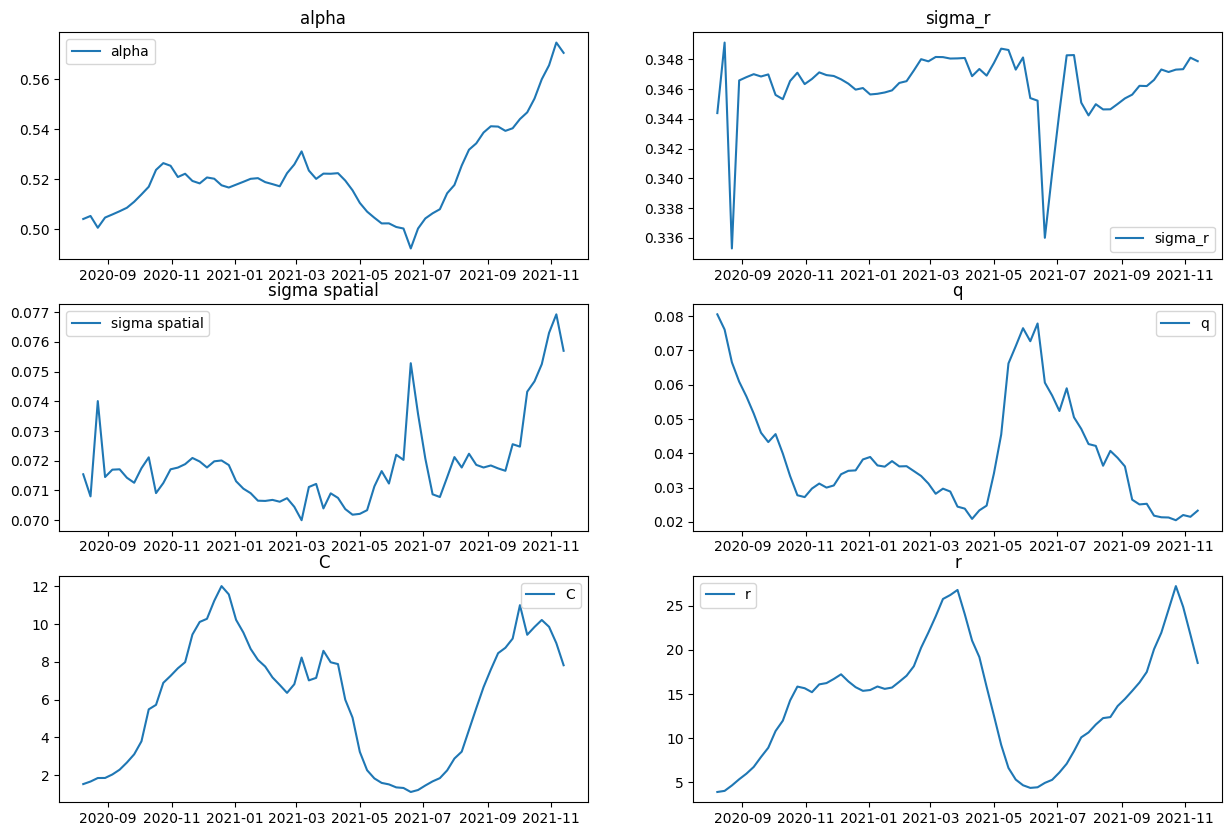

In [14]:
df_params["date"] = pd.to_datetime(df_params["date"])

plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for col, ax in zip(df_params.columns[:-1], axs.flatten()):
    ax.plot(df_params["date"], df_params[col], label=col)
    ax.set_title(col)
    ax.legend()